In [ ]:
# Import necessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score

import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import numpy as np
import cv2
import os

# Ensure GPU acceleration is active
# You will want GPU acceleration to train the model, it is a very slow process otherwise.
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Overview

This Jupyter Notebook presents the development and analysis of a Convolutional Neural Network (CNN) model for car manufacturer recognition. The project aims to address the following research question:

Do distinct design languages exist across different car manufacturers, and do these design languages cluster based on regional or national origins?

The notebook is organized as follows:

1.  Data Overview: Provides insights into the dataset used for training and evaluation.
2.  Data Import and Preprocessing: Covers the steps involved in loading and preparing the data for the CNN model.
3.  Model Training: Details the architecture and training process of the chosen CNN model.
4.  Model Evaluation: Evaluates the performance of the trained model.
5.  Visualization and Analysis: Presents visualizations and analysis to answer the research question.
6.  Conclusions: Summarizes the findings and answers the research question based on the visualizations and analysis.


# Data Overview

The dataset used for this project is the Stanford Cars Dataset, sourced from:

[https://github.com/jhpohovey/StanfordCars-Dataset](https://github.com/jhpohovey/StanfordCars-Dataset)

The dataset contains images of 196 different car models, labeled by their manufacturer, country, and region.


# Data Import and Preprocessing

The following code snippets demonstrate the process of loading and preprocessing the data:


In [ ]:
def preprocess_image(image_path, bbox):
    """Loads an image, crops it to the bounding box, resizes it, and normalizes it."""
    img = cv2.imread(image_path)
    img = img[bbox[1]:bbox[3], bbox[0]:bbox[2]]
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    return img

# Load the classes
df_classes = pd.read_csv("Data/class_names_manufacturer_country_region_grouped.csv")
class_names = {index: row["manufacturer"] for index, row in df_classes.iterrows()}

# File paths to save the preprocessed data
x_train_path = "Data/x_train.npy"
y_train_path = "Data/y_train.npy"

# Check if preprocessed data is already saved locally
if os.path.exists(x_train_path) and os.path.exists(y_train_path):
    # Load the preprocessed data
    x_train = np.load(x_train_path)
    y_train = np.load(y_train_path)
else:
    # Preprocess the training data
    df_train = pd.read_csv("Data/annotations_train_grouped.csv")
    x_train = []
    y_train = []
    for i, row in df_train.iterrows():
        image_path = f"Data/cars_train/{row['fname'].split('/')[-1]}"
        bbox = [row['bbox_x1'], row['bbox_y1'], row['bbox_x2'], row['bbox_y2']]
        x_train.append(preprocess_image(image_path, bbox))
        y_train.append(row["class"])

    # Convert the data to NumPy arrays
    x_train = np.array(x_train)
    y_train = np.array(y_train)

    # Save the preprocessed data for future usage
    np.save(x_train_path, x_train)
    np.save(y_train_path, y_train)

# Split the training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)


# File paths to save the preprocessed test data
x_test_path = "Data/x_test.npy"
y_test_path = "Data/y_test.npy"

# Check if preprocessed data exists
if os.path.exists(x_test_path) and os.path.exists(y_test_path):
    # Load the preprocessed data
    x_test = np.load(x_test_path)
    y_test = np.load(y_test_path)
else:
    # process the data
    df_test = pd.read_csv("Data/annotations_test_grouped.csv")
    
    x_test = []
    y_test = []
    for i, row in df_test.iterrows():
        image_path = f"Data/cars_test/{row['fname'].split('/')[-1]}"
        bbox = [row['bbox_x1'], row['bbox_y1'], row['bbox_x2'], row['bbox_y2']]
        x_test.append(preprocess_image(image_path, bbox))
        y_test.append(row["class"])

    # Convert the data to NumPy arrays
    x_test = np.array(x_test)
    y_test = np.array(y_test)

    # Save the preprocessed data
    np.save(x_test_path, x_test)
    np.save(y_test_path, y_test)

# Create a smaller representative test set due to the Python kernal crashing when using the full test dataset when evaluating the model.
x_test_small, _, y_test_small, _ = train_test_split(
    x_test, y_test, test_size=0.33, random_state=42, stratify=y_test
)

# Model Training

The project explored various CNN architectures and hyperparameters. The final model chosen for this project is a fine-tuned VGG16 model. If you would like to see some of the other models they are outlined in the "exploration_notebook.ipynb" within this repository.

The following code snippet demonstrates the training process of this model:


In [ ]:
# Load the pretrained VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Unfreeze some layers for fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Create the modified model
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=True)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(256, activation="relu", kernel_regularizer=l2(0.001))(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(49, activation="softmax")(x)
model = keras.Model(inputs, outputs)

# Compile the model
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy"]
)

# Create an ImageDataGenerator for data augmentation used to improve training
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Implement early stopping and learning rate scheduler
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3, min_lr=1e-6)

# Train the model with data augmentation
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, lr_scheduler]
)

# Save the trained model for future usage
model.save("fine_tuned_vgg16_model_from_guided.keras")

Epoch 1/50
204/204 [==============================] - 33s 153ms/step - loss: 3.9203 - accuracy: 0.0896 - val_loss: 3.7537 - val_accuracy: 0.1068 - lr: 1.0000e-04
Epoch 2/50
204/204 [==============================] - 29s 142ms/step - loss: 3.7634 - accuracy: 0.0878 - val_loss: 3.6814 - val_accuracy: 0.0657 - lr: 1.0000e-04
Epoch 3/50
204/204 [==============================] - 30s 148ms/step - loss: 3.6672 - accuracy: 0.0976 - val_loss: 3.5743 - val_accuracy: 0.1068 - lr: 1.0000e-04
Epoch 4/50
204/204 [==============================] - 29s 142ms/step - loss: 3.5802 - accuracy: 0.1045 - val_loss: 3.5050 - val_accuracy: 0.1295 - lr: 1.0000e-04
Epoch 5/50
204/204 [==============================] - 29s 142ms/step - loss: 3.4911 - accuracy: 0.1291 - val_loss: 3.2288 - val_accuracy: 0.1891 - lr: 1.0000e-04
Epoch 6/50
204/204 [==============================] - 30s 145ms/step - loss: 3.2253 - accuracy: 0.2026 - val_loss: 2.9044 - val_accuracy: 0.2572 - lr: 1.0000e-04
Epoch 7/50
204/204 [========

# Model Evaluation

The following code snippet evaluates the performance of the trained model on a smaller representative test set:


In [ ]:
#Load our trained model for testing!
model = keras.models.load_model("fine_tuned_vgg16_model.keras")

try:
    # Evaluate the model on the smaller test set
    loss, accuracy = model.evaluate(x_test_small, y_test_small)
    print("Test accuracy (small set):", accuracy)

except Exception as e:
    print(f"An error occurred during evaluation: {e}")
    import traceback
    traceback.print_exc()

169/169 [==============================] - 4s 23ms/step - loss: 0.3548 - accuracy: 0.9393
Test accuracy (small set): 0.9392982721328735


# Visualization and Analysis

The following code snippets generate visualizations and perform statistical analysis to answer the research question:


In [27]:
# Generate some visualizations of characteristics and statistics
# Load the trained model
model = keras.models.load_model("fine_tuned_vgg16_model.keras")

# Extract features from the penultimate layer
feature_extractor = keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)
features = feature_extractor.predict(x_test_small)

# Apply PCA to reduce dimensionality to 2 components
pca = PCA(n_components=2)
reduced_features_pca = pca.fit_transform(features)

# Apply t-SNE to reduce dimensionality to 2 components
tsne = TSNE(n_components=2, random_state=42)
reduced_features_tsne = tsne.fit_transform(features)

169/169 [==============================] - 1s 3ms/step


## Visualizations by Manufacturer

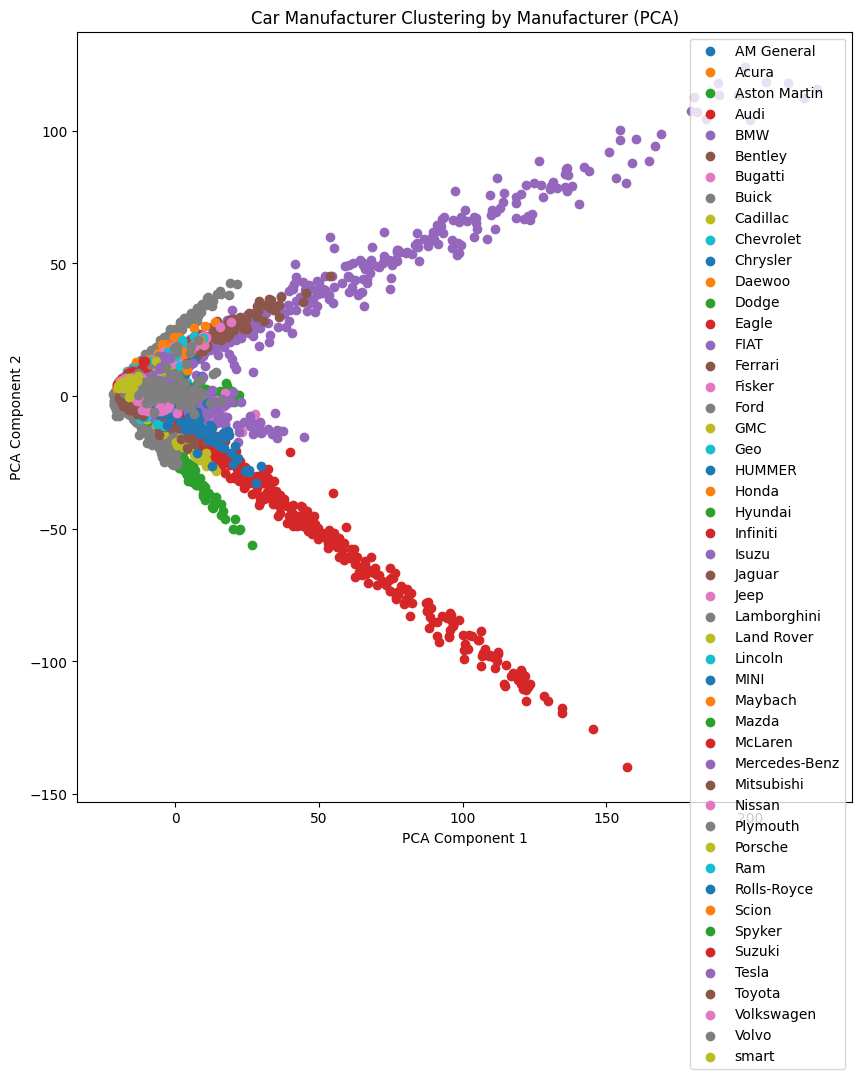

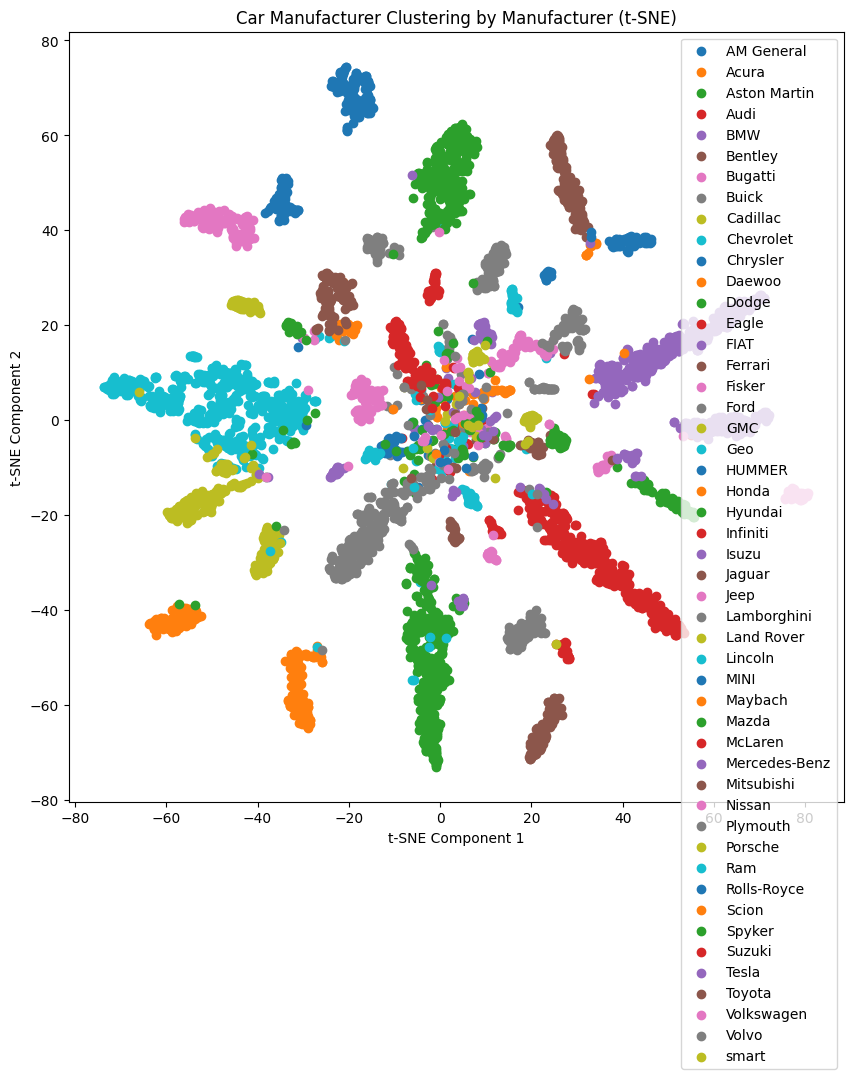

In [ ]:
# Plot PCA visualization by manufacturer
plt.figure(figsize=(10, 10))
for manufacturer in df_grouped["manufacturer"].unique():
    manufacturer_index = df_grouped[df_grouped["manufacturer"] == manufacturer].index[0]
    plt.scatter(
        reduced_features_pca[y_test_small == manufacturer_index, 0],
        reduced_features_pca[y_test_small == manufacturer_index, 1],
        label=manufacturer,
    )
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Car Manufacturer Clustering by Manufacturer (PCA)")
plt.legend()
plt.show()

# Plot t-SNE visualization by manufacturer
plt.figure(figsize=(10, 10))
for manufacturer in df_grouped["manufacturer"].unique():
    manufacturer_index = df_grouped[df_grouped["manufacturer"] == manufacturer].index[0]
    plt.scatter(
        reduced_features_tsne[y_test_small == manufacturer_index, 0],
        reduced_features_tsne[y_test_small == manufacturer_index, 1],
        label=manufacturer,
    )
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Car Manufacturer Clustering by Manufacturer (t-SNE)")
plt.legend()
plt.show()

## Visualizations by Country

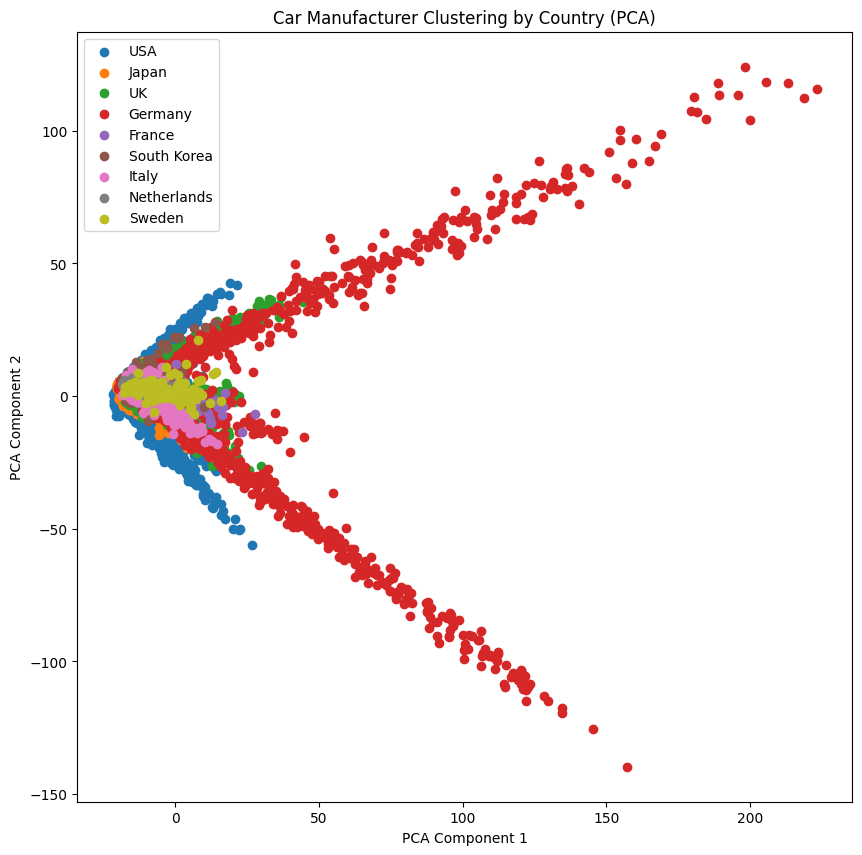

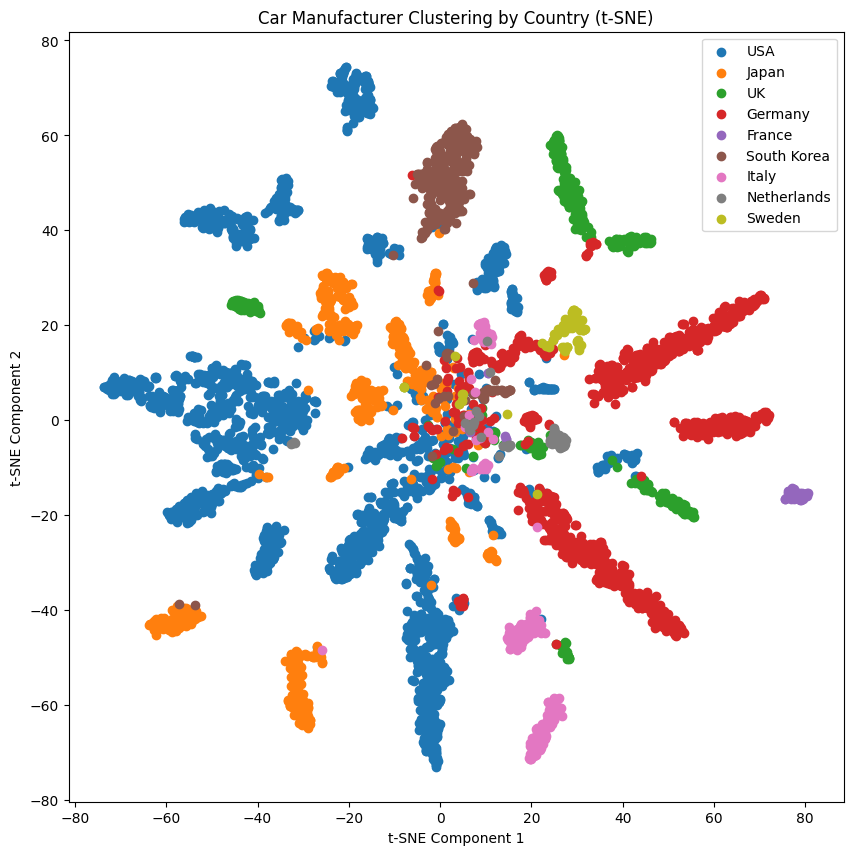

In [ ]:
# Plot PCA visualization by country
plt.figure(figsize=(10, 10))
for country in df_grouped["country"].unique():
    country_indices = df_grouped[df_grouped["country"] == country].index
    plt.scatter(
        reduced_features_pca[np.isin(y_test_small, country_indices), 0],
        reduced_features_pca[np.isin(y_test_small, country_indices), 1],
        label=country,
    )
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Car Manufacturer Clustering by Country (PCA)")
plt.legend()
plt.show()

# Plot t-SNE visualization by country
plt.figure(figsize=(10, 10))
for country in df_grouped["country"].unique():
    country_indices = df_grouped[df_grouped["country"] == country].index
    plt.scatter(
        reduced_features_tsne[np.isin(y_test_small, country_indices), 0],
        reduced_features_tsne[np.isin(y_test_small, country_indices), 1],
        label=country,
    )
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Car Manufacturer Clustering by Country (t-SNE)")
plt.legend()
plt.show()

## Visualizations by Region

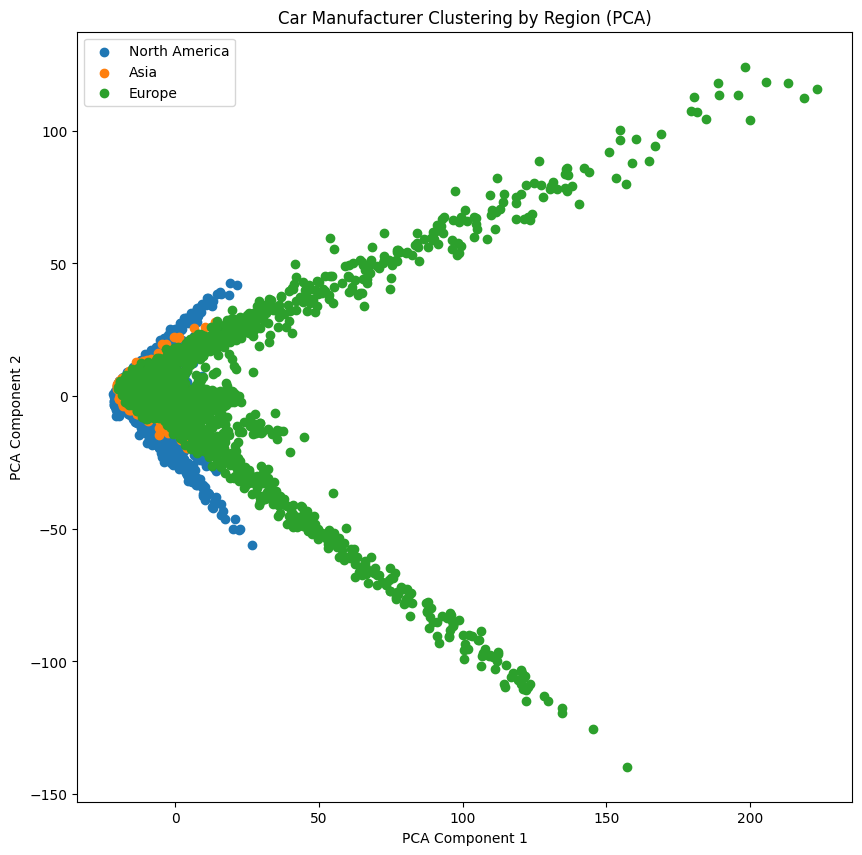

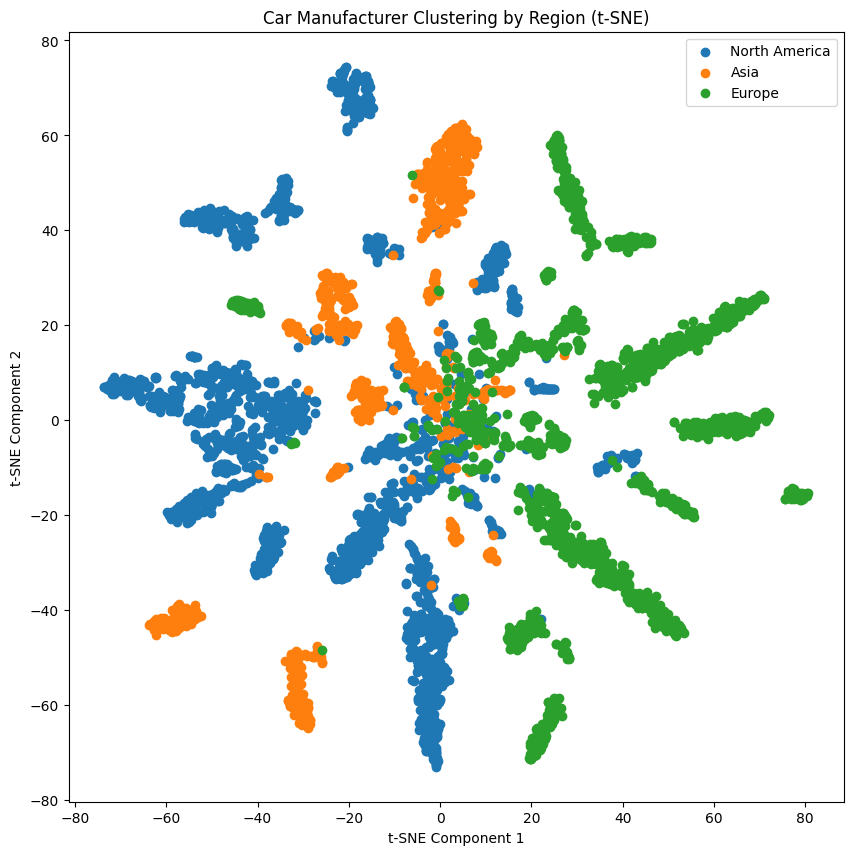

In [ ]:
# Plot PCA visualization by region
plt.figure(figsize=(10, 10))
for region in df_grouped["region"].unique():
    region_indices = df_grouped[df_grouped["region"] == region].index
    plt.scatter(
        reduced_features_pca[np.isin(y_test_small, region_indices), 0],
        reduced_features_pca[np.isin(y_test_small, region_indices), 1],
        label=region,
    )
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Car Manufacturer Clustering by Region (PCA)")
plt.legend()
plt.show()

# Plot t-SNE visualization by region
plt.figure(figsize=(10, 10))
for region in df_grouped["region"].unique():
    region_indices = df_grouped[df_grouped["region"] == region].index
    plt.scatter(
        reduced_features_tsne[np.isin(y_test_small, region_indices), 0],
        reduced_features_tsne[np.isin(y_test_small, region_indices), 1],
        label=region,
    )
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Car Manufacturer Clustering by Region (t-SNE)")
plt.legend()
plt.show()

## Statistical Analysis

In [31]:
# --- Statistical Analysis ---

# Calculate Silhouette Score for PCA
silhouette_pca = silhouette_score(reduced_features_pca, y_test_small)
print(f"Silhouette Score (PCA): {silhouette_pca}")

# Calculate Davies-Bouldin Score for PCA
davies_bouldin_pca = davies_bouldin_score(reduced_features_pca, y_test_small)
print(f"Davies-Bouldin Score (PCA): {davies_bouldin_pca}")

# Calculate Silhouette Score for t-SNE
silhouette_tsne = silhouette_score(reduced_features_tsne, y_test_small)
print(f"Silhouette Score (t-SNE): {silhouette_tsne}")

# Calculate Davies-Bouldin Score for t-SNE
davies_bouldin_tsne = davies_bouldin_score(reduced_features_tsne, y_test_small)
print(f"Davies-Bouldin Score (t-SNE): {davies_bouldin_tsne}")

Silhouette Score (PCA): -0.31093111634254456
Davies-Bouldin Score (PCA): 6.8512645670283545
Silhouette Score (t-SNE): 0.1965111941099167
Davies-Bouldin Score (t-SNE): 2.4693860034287676


## 3D Interactive Visualizations

To further explore the clustering patterns and gain a more intuitive understanding of the relationships between car manufacturers based on their design features, we can leverage interactive 3D visualizations. These visualizations allow us to rotate, zoom, and pan the data points, providing a more comprehensive view of the clusters and potential outliers.

In [32]:
# Extract features from the penultimate layer
feature_extractor = keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)
features = feature_extractor.predict(x_test_small)

# Apply PCA to reduce dimensionality to 3 components
pca = PCA(n_components=3)
reduced_features = pca.fit_transform(features)

# Create a DataFrame for Plotly
df = pd.DataFrame(reduced_features, columns=["PCA Component 1", "PCA Component 2", "PCA Component 3"])
df["manufacturer"] = [class_names[label] for label in y_test_small]
df["country"] = [df_grouped[df_grouped["manufacturer"] == m]["country"].values[0] for m in df["manufacturer"]]
df["region"] = [df_grouped[df_grouped["manufacturer"] == m]["region"].values[0] for m in df["manufacturer"]]


169/169 [==============================] - 1s 3ms/step


In [33]:

# Interactive 3D visualization by manufacturer
fig_manufacturer = px.scatter_3d(
    df,
    x="PCA Component 1",
    y="PCA Component 2",
    z="PCA Component 3",
    color="manufacturer",
    hover_name="manufacturer",
    title="Car Manufacturer Clustering by Manufacturer (PCA, 3D)",
)
fig_manufacturer.show()


In [34]:

# Interactive 3D visualization by country
fig_country = px.scatter_3d(
    df,
    x="PCA Component 1",
    y="PCA Component 2",
    z="PCA Component 3",
    color="country",
    hover_name="manufacturer",
    title="Car Manufacturer Clustering by Country (PCA, 3D)",
)
fig_country.show()


In [35]:

# Interactive 3D visualization by region
fig_region = px.scatter_3d(
    df,
    x="PCA Component 1",
    y="PCA Component 2",
    z="PCA Component 3",
    color="region",
    hover_name="manufacturer",
    title="Car Manufacturer Clustering by Region (PCA, 3D)",
)
fig_region.show()

# Conclusions

Based on the visualizations and statistical analysis, we can draw the following conclusions:

*   There is evidence to suggest that distinct design languages exist across different car manufacturers. The t-SNE visualization, in particular, shows some degree of clustering based on countries, indicating regional influences on car design.
*   However, the clustering is not perfect, and there is overlap between clusters. This suggests that while regional influences might be present, global design trends also play a significant role in shaping car design aesthetics.
*   The quantitative analysis using Silhouette Score and Davies-Bouldin Index confirms that the clustering is not very distinct, especially with PCA. t-SNE provides slightly better-defined clusters.
*   Further analysis, such as investigating feature importance and exploring other dimensionality reduction techniques, could provide more nuanced insights into the relationship between car design and regional or national origins.

Overall, the project provides some evidence to support the research question, but it also highlights the complexity of the relationship between car design and regional influences. The visualizations and analysis suggest that both regional and global factors contribute to the design languages of different car manufacturers.